<a href="https://colab.research.google.com/github/cristinarainich/DDCS/blob/main/rvh_termin1only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import pylab as pl
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
working_path = Path('/content/gdrive/MyDrive/KKNV/rvh')

In [4]:
!ls /content/gdrive/MyDrive/KKNV/rvh

rvh_termin1.xlsx


In [5]:
rvh = pd.read_excel(working_path.joinpath('rvh_termin1.xlsx'), index_col=None)


In [6]:
rvh = rvh.rename(columns={'Total trials': 'Total_trials',
                          'Initial threshold': 'Initial_thr',
                          'Left ET': 'left_ET',
                          'Left SE': 'left_SE',
                          'Left SD': 'left_SD',
                          'Right ET': 'right_ET',
                          'Right SE': 'right_SE',
                          'Right SD': 'right_SD'})

In [7]:
rvh.Is_staircase_completed_left = rvh.Is_staircase_completed_left.astype(int)
rvh.Is_staircase_completed_right = rvh.Is_staircase_completed_right.astype(int)

Now we a gonna create a copy of the initial threshold to continue with the analysis and to add some infor about the participants that we have.

In [8]:
rvh_analysis = rvh.copy()
rvh_analysis = rvh_analysis[rvh_analysis['Is_staircase_completed_left'] == 1]
rvh_analysis = rvh_analysis[rvh_analysis['Is_staircase_completed_right'] == 1]
# leaving only the trials where people performed the staircase successfully

# excluding subjects who are from other startegy in initial threshold
subjects = ['DD01', 'DD02', 'DD03', 'DD04', 'DD05', 'DD06', 'DD07',
            'TD01', 'TD02', 'TD03', 'TD04', 'TD05', 'TD06', 'TD07']
for i in subjects:
  rvh_analysis = rvh_analysis[rvh_analysis['Subject'] != i]

In [9]:
rvh_analysis.Total_trials = rvh_analysis.Total_trials.astype(int)
rvh_analysis.Initial_thr = rvh_analysis.Initial_thr.astype(float)

In [ ]:
# computing SD across runs - how consistent this subject across runs

In [10]:
rvh_summary = (
    rvh_analysis
    .groupby('Subject')
    .agg(
        mean_left_ET = ('left_ET', 'mean'),
        mean_right_ET = ('right_ET', 'mean'),
        mean_left_accuracy = ('Left_accuracy', 'mean'),
        mean_right_accuracy = ('Right_accuracy', 'mean'),
        n_runs = ('Run', 'count'),
        sd_left_ET = ('left_ET', 'std'),
        sd_right_ET = ('right_ET', 'std'),
        sd_left_accuracy = ('Left_accuracy', 'std'),
        sd_right_accuracy = ('Right_accuracy', 'std')
    )
    .reset_index()
)

In [11]:
column_group = []
subject_ids = rvh_summary.Subject.values.tolist()
for i in subject_ids:
  if 'DD' in i:
    column_group.append('DD')
  elif 'TD' in i:
    column_group.append('TD')
print(rvh_summary.shape)
print(len(column_group))
rvh_summary['Group'] = column_group

(36, 10)
36


In [15]:
# male = 0, female = 1
sex = [0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 'excl', 1, 1, 0, 1, 1, 0, 1, 1, 1]
age = [32, 22, 30, 23, 34, 32, 34, 21, 28, 23, 45, 20, 42, 26, 18, 21, 'unknown', 23, 23, 20, 21, 28, 19,
       28, 30, 44, 'excl', 42, 20, 23, 20, 22, 23, 39, 41, 'unknown']
nvIQ = [122, 102, 104, 'unknown', 102, 113, 92, 100, 135, 87, 106, 96, 100, 96, 100, 118,
        108, 117, 'unknown', 'unknown', 'unknown', 'unknown', 'unknown',
        89, 150, 120, 'excl', 100, 102, 137, 'unknown', 104, 98, 102, 127, 'unknown']
print(rvh_summary.shape)
print(len(sex))
print(len(age))
print(len(nvIQ))


(36, 11)
36
36
36


In [16]:
rvh_summary['Age'] = age
rvh_summary['Sex'] = sex
rvh_summary['nvIQ'] = nvIQ

In [19]:
rvh_summary = rvh_summary[rvh_summary['Subject'] != 'TD13']

In [28]:
# check the difference between the groups for who i have the necessary information
from scipy.stats import ttest_ind

# comparing age using Welch t-test
t_age, p_age = ttest_ind(
    rvh_summary[(rvh_summary['Group'] == 'DD') & (rvh_summary['Age'] != 'unknown')]['Age'].values.tolist(),
    rvh_summary[(rvh_summary['Group'] == 'TD') & (rvh_summary['Age'] != 'unknown')]['Age'].values.tolist(),
    equal_var = False
)
print('Age comparison: ',
      rvh_summary[(rvh_summary['Group'] == 'DD') & (rvh_summary['Age'] != 'unknown')].shape[0], ' DDs and ',
      rvh_summary[(rvh_summary['Group'] == 'TD') & (rvh_summary['Age'] != 'unknown')].shape[0], ' TDs')
print('The age difference between the groups: ', t_age, p_age)
print('')

# comparing nvIQ
t_nviq, p_nviq = ttest_ind(
    rvh_summary[(rvh_summary['Group'] == 'DD') & (rvh_summary['nvIQ'] != 'unknown')]['nvIQ'].values.tolist(),
    rvh_summary[(rvh_summary['Group'] == 'TD') & (rvh_summary['nvIQ'] != 'unknown')]['nvIQ'].values.tolist(),
    equal_var = False
)
print('nvIQ comparison: ',
      rvh_summary[(rvh_summary['Group'] == 'DD') & (rvh_summary['nvIQ'] != 'unknown')].shape[0], ' DDs and ',
      rvh_summary[(rvh_summary['Group'] == 'TD') & (rvh_summary['nvIQ'] != 'unknown')].shape[0], ' TDs')
print('The nvIQ difference between the groups: ', t_nviq, p_nviq)
print('')

# sex comparison Chi-square or Fischer
from scipy.stats import chi2_contingency, fisher_exact
sex_table = pd.crosstab(rvh_summary['Group'], rvh_summary['Sex'])
chi2, p_sex, dof, expected = chi2_contingency(sex_table)
print(expected)
oddsratio, p_sex = fisher_exact(sex_table)
print(oddsratio, p_sex)

Age comparison:  22  DDs and  11  TDs
The age difference between the groups:  -1.0962227612473765 0.28899636553434827

nvIQ comparison:  17  DDs and  10  TDs
The nvIQ difference between the groups:  -1.0384707304171539 0.3179253594660476

[[ 9.2 13.8]
 [ 4.8  7.2]]
2.75 0.2816351501668521


In [52]:
# running an anova
long_df = rvh_summary.melt(
    id_vars=['Subject', 'Group'],
    value_vars=['mean_left_ET', 'mean_right_ET'],
    var_name='Hemifield',
    value_name='ET'
)

long_df['Hemifield'] = long_df['Hemifield'].map({
    'mean_left_ET': 'Left',
    'mean_right_ET': 'Right'
})

long_df = long_df.dropna(subset=['ET'])

import statsmodels.formula.api as smf

model = smf.mixedlm(
    "ET ~ Group * Hemifield",
    long_df,
    groups=long_df["Subject"]
)

result = model.fit()
print(result.summary())



                  Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       ET      
No. Observations:        70            Method:                   REML    
No. Groups:              35            Scale:                    0.1074  
Min. group size:         2             Log-Likelihood:           -62.0730
Max. group size:         2             Converged:                Yes     
Mean group size:         2.0                                             
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       2.888    0.154 18.813 0.000  2.587  3.189
Group[T.TD]                    -0.416    0.262 -1.587 0.112 -0.930  0.098
Hemifield[T.Right]             -0.432    0.097 -4.465 0.000 -0.621 -0.242
Group[T.TD]:Hemifield[T.Right]  0.027    0.165  0.166 0.

In [47]:
# now let's reduce to people who have the accuracy above 65 %
rvh_summary1 = rvh_summary[(rvh_summary['mean_left_accuracy'] > 70) & (rvh_summary['mean_right_accuracy'] > 70)]
print(rvh_summary.shape)
print(rvh_summary1.shape)

# running an anova
long_df = rvh_summary1.melt(
    id_vars=['Subject', 'Group'],
    value_vars=['mean_left_ET', 'mean_right_ET'],
    var_name='Hemifield',
    value_name='ET'
)

long_df['Hemifield'] = long_df['Hemifield'].map({
    'mean_left_ET': 'Left',
    'mean_right_ET': 'Right'
})

long_df = long_df.dropna(subset=['ET'])

import statsmodels.formula.api as smf

model = smf.mixedlm(
    "ET ~ Group * Hemifield",
    long_df,
    groups=long_df["Subject"]
)

result = model.fit()
print(result.summary())


(35, 14)
(26, 14)
                  Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       ET      
No. Observations:        52            Method:                   REML    
No. Groups:              26            Scale:                    0.1232  
Min. group size:         2             Log-Likelihood:           -41.1143
Max. group size:         2             Converged:                Yes     
Mean group size:         2.0                                             
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       2.525    0.146 17.268 0.000  2.238  2.811
Group[T.TD]                    -0.230    0.236 -0.974 0.330 -0.692  0.232
Hemifield[T.Right]             -0.422    0.124 -3.401 0.001 -0.665 -0.179
Group[T.TD]:Hemifield[T.Right]  0.118 

In [57]:
rvh_summary[rvh_summary['Group'] == 'DD']

,Subject,mean_left_ET,mean_right_ET,mean_left_accuracy,mean_right_accuracy,n_runs,sd_left_ET,sd_right_ET,sd_left_accuracy,sd_right_accuracy,Group,Age,Sex,nvIQ
0,DD08,3.032564,2.488561,66.106717,76.871271,3,0.230310,0.162915,12.723789,10.042200,DD,32,0,122
1,DD09,1.960754,1.634630,78.886397,83.228275,3,0.277483,0.460699,0.775519,5.208114,DD,22,0,102
2,DD10,3.913129,3.017500,63.276353,80.230880,3,0.407063,0.596495,2.137322,8.652821,DD,30,1,104
3,DD11,4.568116,4.355000,58.342603,58.696581,2,0.341461,0.494975,0.393274,1.299384,DD,23,1,unknown
4,DD12,3.169139,3.225917,74.924465,74.310491,4,0.179870,0.208547,3.196028,12.144068,DD,34,0,102
5,DD13,1.826680,1.446212,83.022999,89.340327,3,0.115191,0.179348,2.993486,1.680136,DD,32,1,113
6,DD14,3.114167,3.105286,75.295184,78.632479,3,0.397180,0.321479,8.481823,8.180708,DD,34,1,92
7,DD15,2.985278,2.821667,75.495782,83.281461,3,0.544208,0.301759,20.705465,8.384238,DD,21,1,100
8,DD16,1.646071,1.434091,81.771835,82.257884,3,0.225277,0.185044,1.567804,5.598471,DD,28,0,135
9,DD17,2.576833,1.606667,74.228755,87.525253,3,0.448996,0.328684,3.074654,3.046673,DD,23,1,87


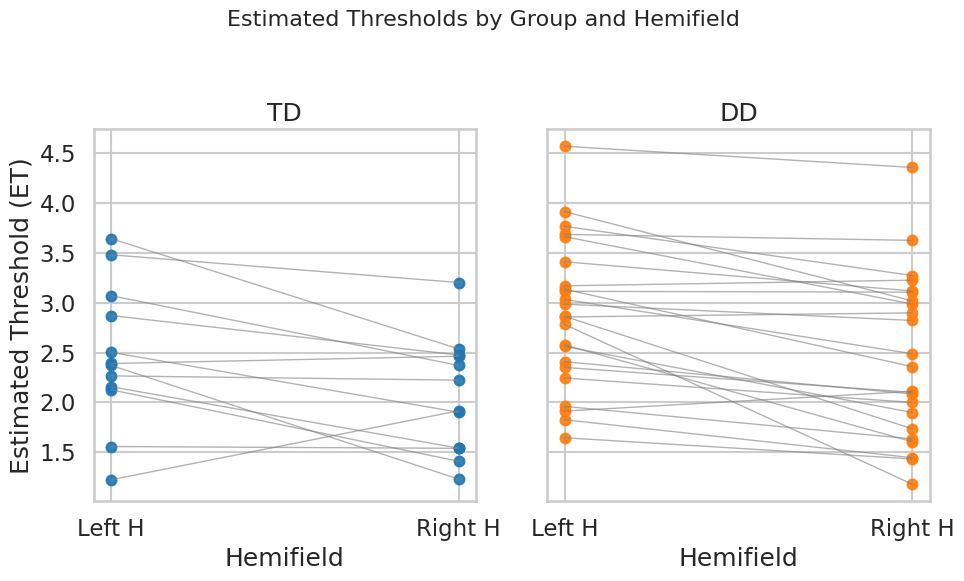

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk")

# Sort hemifield for consistent ordering
long_df['Hemifield'] = pd.Categorical(long_df['Hemifield'], categories=['Left', 'Right'], ordered=True)

fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

group_names = {'TD': 'TD', 'DD': 'DD'}
colors = {'TD': 'tab:blue', 'DD': 'tab:orange'}

for ax, group in zip(axs, ['TD', 'DD']):
    sub_data = long_df[long_df['Group'] == group]
    subjects = sub_data['Subject'].unique()

    for subj in subjects:
        subj_data = sub_data[sub_data['Subject'] == subj]

        if set(subj_data['Hemifield']) == {'Left', 'Right'}:
            x = [0, 1]  # LVF, RVF on x axis
            y = subj_data.sort_values('Hemifield')['ET'].values

            # Connect points with gray line
            ax.plot(x, y, color='gray', alpha=0.6, linewidth=1)

            # Plot dots in group color
            ax.scatter(x, y, s=50, alpha=0.9, color=colors[group])

    ax.set_title(group_names[group])
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Left H', 'Right H'])
    ax.set_xlabel('Hemifield')

axs[0].set_ylabel('Estimated Threshold (ET)')
plt.suptitle('Estimated Thresholds by Group and Hemifield', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

